## Captcha Breaker using Multi-Class Classification

Captchas were invented to prevent bots from attacking websites. But the ML models are breaking captchas. Thus, stronger captchas are being invented. In this part, we will train a ML model to break hcaptcha (https://www.hcaptcha.com/ )!!

Please download the following dataset: https://github.com/sarang-iitb/H-captcha-dataset

### 0. Load the dataset

In [2]:
# cloning
!git clone https://github.com/sarang-iitb/H-captcha-dataset

Cloning into 'H-captcha-dataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [3]:
import zipfile
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [4]:
unzip_data('/content/H-captcha-dataset/hcaptcha_dataset.zip')

### 1. Data Cleaning and Visualization

a) Seeing the labels in the dataset. Number of images belonging to each class?

In [5]:
import glob
classes=glob.glob('hcaptcha_dataset/train/*')
imagesbyclass={}
classes=list(map(lambda x: x.split("/")[-1], classes))
print("labels: ", classes)
for x in classes:
  imagesbyclass[x.split("/")[-1]]=len(glob.glob('hcaptcha_dataset/train/'+x+'/*.jpg'))+len(glob.glob('hcaptcha_dataset/test/'+x+'/*.jpg'))
print(imagesbyclass)

labels:  ['boat', 'truck', 'bicycle', 'motorbus', 'motorcycle', 'airplane', 'seaplane']
{'boat': 662, 'truck': 819, 'bicycle': 375, 'motorbus': 317, 'motorcycle': 733, 'airplane': 503, 'seaplane': 355}


Number of train and test images are present in the given dataset

In [6]:
test_images = glob.glob('hcaptcha_dataset/test/*/*.jpg')
training_images=glob.glob('hcaptcha_dataset/train/*/*.jpg')
print("Total number of testing images: ", len(test_images))
print("Total number of training images: ", len(training_images))

Total number of testing images:  746
Total number of training images:  3018


Displaying a random image and its shape. Checking if the shape of all the images are same or not

(128, 128, 3)


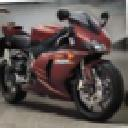

motorcycle
Not same shape


In [7]:
from re import L
import random
import cv2
import os
from google.colab.patches import cv2_imshow

def rand_img_visualize():
  images=glob.glob('hcaptcha_dataset/train/*/*.jpg')
  random_image=random.choice(images)
  image = cv2.imread(random_image, cv2.IMREAD_UNCHANGED) 
  print(image.shape)
  cv2_imshow( image)
  print(random_image.split('/')[-2])

rand_img_visualize()
images=glob.glob('hcaptcha_dataset/train/*/*.jpg')
image = cv2.imread(images[0], cv2.IMREAD_UNCHANGED) 
for x in images:
  if(cv2.imread(x, cv2.IMREAD_UNCHANGED).shape!=image.shape):
    print("Not same shape")
    break

for x in images:
  img=cv2.imread(x)
  dsize = (image.shape[0], image.shape[0]) 
  #making all images of shape(128,128)
  img=cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(x,img) 



Removing color channels (R, G, B) from images would not lead to poor modeling.

Since color has no significance in our classification problem, its better to go for grey scale images to avoid false classification and complexities. If suppose we had to classify fruits , then color of images woud have held significance because if we had to distinguish between apple and orange, they both are very similar in shape, but color becomes the main differentiating factor is the color. But in our classification problem the images of objects that we have are much different in their shape only, so its better to have grey scale images.

We are more interested in shape characteristics of the image and colour channels might not give much information about the shape. Using a colored 3 channel image will make the model very complex.

Using a colored 3-channel image over a grayscale one on the classification model’s performance, the model will become more complex. As RGB channels are 3-dimensional, the model will use more space and time unneccesarily. 3 channeled image will have more information but will not be relevant.

Moreover, Many algorithms are customized to work only on grayscale images.

We should normailze our data. Image normalization is a process in image that changes the range of pixel intensity values. Its main purpose is to ensure that input parameter (pixel) has a similar data distribution. This makes convergence faster while training the network. By normalizing each channel so that they have the same distribution, we ensure that the channel information can be mixed and updated during the gradient descent using the same learning rate.

It involves calibrating the different pixels intensities into a normal distribution which makes the image looks better for the visualizer.For example,very dark images become clearer.

In [8]:
#Normalizing the image

import numpy as np
images=glob.glob('hcaptcha_dataset/train/*/*.jpg')
for x in images:
  norm = np.zeros((800,800))
  image=cv2.imread(x, cv2.IMREAD_UNCHANGED)
  normalized_image = cv2.normalize(image,norm,0,255,cv2.NORM_MINMAX)
  cv2.imwrite(x,normalized_image)


Visualize some random training images along with the labels for each class.

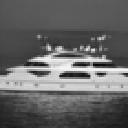

(128, 128)
boat


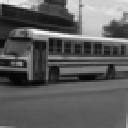

(128, 128)
motorbus


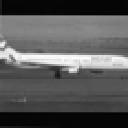

(128, 128)
airplane


In [9]:
for i in range (1,4):
  random_image=random.choice(images)
  image = cv2.imread(random_image, cv2.IMREAD_UNCHANGED) 
  cv2_imshow(image)
  print(image.shape)
  print(random_image.split('/')[-2])

### 2. Preparing Balanced Samples for Training using only the Training set provided to you.

In the current dataset the images are classified into their classes, and if we load all the images of the training
dataset in a single list, then all the images of same type will be together i.e.,the list will first contain all the images of the class airplane, then all images of class boat, then all images of class ship and so on.
So if we apply cross validation on this dataset, all the folds will not be similar. A single fold will contain mostly images of a single class only.  We want
that  our training set should be such that after applying cross validation in all the folds the pecentage of images from each class should be nearly same.
This will lead to better modelling.



To ensure that every fold contains images from each class, we can implement something like StratifiedKFold.
On StratifiedKFold, each set contains approximately the same percentage of samples of each target
class as the complete set.

In k fold cross validation we assume k=10, (k is mostly chosen as 5 or 10) and then shuffle the data set in such a way that each 
consecutive 10% of data have same percentage of images from each class.
So to do this, we rebuild the array in the following way:
Take k% images from each class in order one by one and add it to the array.
First take k% images from class 1 and add to array , then  takek% images from class 2 and add to array, 
take k% images from class 3 and add to array, ..so on till last class .
Do this for k times till all the images are added in the new dataset.

Example : There are 2 classes, class A has 20 values and class B has 50 values. Then in our list we first pick 2 elemnts from class A, then 3 elements from class B , then again 2 elements from class A , 3 from class B so on (k=10) times.

Also this would ensure no duplicates in our test set since simple k fold picks the elements in the folds linearly. So once an element has been added into the test set, next time elements from aother fold will be in the test set.

In [10]:
# Making a new dataset that whose k folds will be similar

new_dataset=[]

for i in range(1,11):
  for label in classes:
    class_images=glob.glob('hcaptcha_dataset/train/'+label+'/*.jpg')
    l=len(class_images)
    start=int((i-1)*(l/10))
    end=int(i*(l/10))
    if i==10 and end<l :
      end=l
    for index in range(start-1, end):
      new_dataset.append(class_images[index])

In [11]:
#Checking that each fold in cross validation is similar data in our newdataset i.e., no fold has 0 image of any class 
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)

for train_index, test_index in kf.split(new_dataset):
  count_airplane=0
  count_bicycle=0
  count_boat=0
  count_motorbus=0
  count_motorcycle=0
  count_seaplane=0
  count_truck=0
  for i in range(0,len(test_index)):
    label=new_dataset[i].split('/')[-2]

    if(label=='airplane'):
      count_airplane+=1
    elif(label=='bicycle'):
      count_bicycle+=1
    elif(label=='boat'):
      count_boat+=1
    elif(label=='motorbus'):
      count_motorbus+=1
    elif(label=='motorcycle'):
      count_motorcycle+=1
    elif(label=='seaplane'):
      count_seaplane+=1
    elif(label=='truck'):
      count_truck+=1

  if(count_airplane==0 or count_boat==0 or count_bicycle==0 or count_motorbus==0 or count_seaplane==0 or count_motorcycle==0 or count_truck==0):
    print("Invalid shuffling")
  else:
    print("Valid Shuffling")


Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling


In [12]:
# Creating the image_data and target data to use in sklearn
image_data=[]
target=[]
for i in new_dataset:
  img=cv2.imread(i, cv2.IMREAD_UNCHANGED)
  # cv2_imshow(img)
  img=img.flatten()
  image_data.append(img)
  # cv2_imshow(img)
  label=i.split('/')[-2]
  if(label=='airplane'):
    target.append(1)
  elif(label=='bicycle'):
    target.append(2)
  elif(label=='boat'):
    target.append(3)
  elif(label=='motorbus'):
    target.append(4)
  elif(label=='motorcycle'):
    target.append(5)
  elif(label=='seaplane'):
    target.append(6)
  elif(label=='truck'):
    target.append(7)

image_data=np.array(image_data)
target=np.array(target)

By default, logistic regression is used for binary classification problems.
It requires modification to support multi-class classification problems.
In our case, extending logistic regression to multi class classification will make the model  very complex and will not be a good choics. It will use more time and memory.

The algorithms that can be used for this classification problem are: knn classifiers and SVM classifiers. Learning with prototypes cannot be used because it is for binary classification and decision trees cannot be used because we cannot make such definite rules for the decision tree as there are not concrete deciding parameters in image classification.


### 4. Training the KNN classifier algorithm on the training dataset without using the test set 

Distance/similarity functionwe use for comparing images.
Comparing at 3 different metrics on a few random samples to get some
understanding of how they work.

We can use eucledian, manhatten distance metrics. However on working further and testing using k fold classification, i found that
manhattan distance gives the best accuracy. Thus we should use Manhattan distance for this problem.


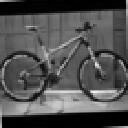

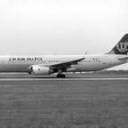

Eucledian Distance: 
17955.037036998838
Cityblock Distance: 
1989713
Cosine Distance: 
0.3466339044746565


In [ ]:
from scipy.spatial import distance
img1=cv2.imread(random.choice(images), cv2.IMREAD_UNCHANGED)
img2=cv2.imread(random.choice(images), cv2.IMREAD_UNCHANGED)
cv2_imshow(img1)
cv2_imshow(img2)
print("Eucledian Distance: ")
print(distance.euclidean(img1.flatten(), img2.flatten()))

print("Cityblock Distance: ")
print(distance.cityblock(img1.flatten(), img2.flatten()))

print("Cosine Distance: ")
print(distance.cosine(img1.flatten(), img2.flatten()))


b) What is the impact of increasing K on the speed and accuracy of the
algorithm? 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
kf=KFold(n_splits=10)
accuracy=[]

for i in range (1,55):
  scores=[]
  knn= KNeighborsClassifier(n_neighbors=i)
  for train_index, test_index in kf.split(image_data):
    x_train, x_test, y_train, y_test= image_data[train_index], image_data[test_index],target[train_index], target[test_index]
    knn.fit(x_train, y_train)
    scores.append(knn.score(x_test, y_test))
  curr_accuracy=(np.array(scores).mean())
  print(curr_accuracy)
  accuracy.append(curr_accuracy)

0.7846446433825075
0.7156642710040769
0.7464264699701593
0.7415647459336779
0.7470821249947465
0.7334730803177405
0.7357437061320556
0.7257018871096541
0.7244042365401588
0.711449796158534
0.7065975286849074
0.7040074811919472
0.701096961291136
0.7001260875047283
0.698510065985794
0.6962383894422729
0.6900884713991511
0.6865296515781953
0.683937502626823
0.6813453536754508
0.6790778800487538
0.6751901819862984
0.6722733577102508
0.6696843609464969
0.6677447148320935
0.6645074181481948
0.6632139704955239
0.658359601563485
0.6590036985668053
0.6567341234816964
0.6538194006640607
0.6541461774471482
0.6515592821418064
0.6502616315723111
0.6486477115117891
0.649617534568991
0.6476757869961753
0.6457277350481234
0.6399035430588829
0.6431376875551634
0.6418442399024923
0.6382822678939183
0.6356922204009583
0.6321312991215904
0.6288929517084858
0.6266254780817888
0.6240364813180347
0.6224173076114824
0.6204745093094608
0.6211207077711932
0.6178876140041188
0.6188616399781448
0.6162694910267725

Text(0, 0.5, 'Accuracy')

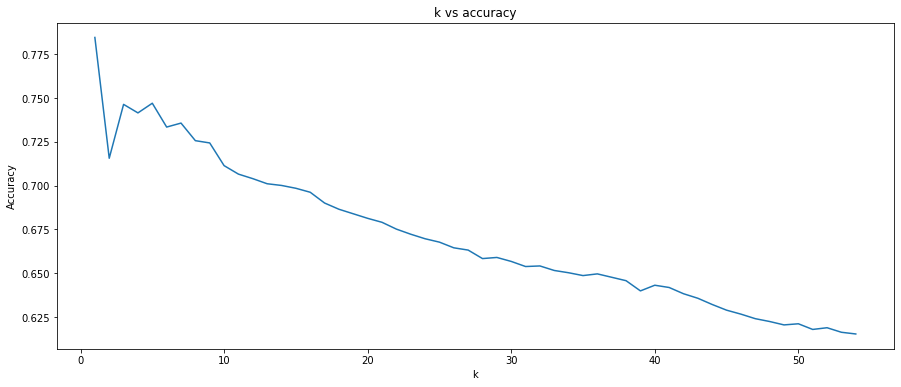

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(range(1,55),accuracy)
plt.title('k vs accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')


The affect of increasing k on accuracy can be seen in the above graph, Intitially on increasing k from 2 to 5 the accuracy increases then accuracy decreases as we go on increasing the value of k. Though it shows best accuracy for k=1, but k=1 might cause overfitting of data, therefore, we choose k=5 which shows the second bext accuracy as the most optimal k value for this classification problem.

Effect on speed:
As Knn algorithm finds the k nearest neighours, so if we increase k it has to find more number of nearest neighours, thus it will take more time to find more neighbours. There are different methods to find k nearest neighours , eg- Brute Force which takes O(n*k) time, d-tree method takes O(k*log(n)) time. (Referenece: https://towardsdatascience.com/k-nearest-neighbors-computational-complexity-502d2c440d5). Thus time is directly proportional to k. Thus increasing k decreases speed.

From the above justification we take the value of k=5, now we have to find the distance metric for the above k. So we take different distance metrics and check its accurracy by cross validation we will select the one with highest cross validation accuracy

In [ ]:
metrics=['euclidean', 'minkowski', 'manhattan', 'cosine', 'l1', 'l2', 'cityblock', 'nan_euclidean']
accuracy_bymetric=[]
for x in metrics:
  scores=[]
  knn= KNeighborsClassifier(n_neighbors=10,metric=x)
  for train_index, test_index in kf.split(image_data):
    x_train, x_test, y_train, y_test= image_data[train_index], image_data[test_index],target[train_index], target[test_index]
    knn.fit(x_train, y_train)
    scores.append(knn.score(x_test, y_test))
  curr_accuracy=(np.array(scores).mean())
  accuracy_bymetric.append(curr_accuracy)

In [ ]:
print(accuracy_bymetric)

[0.711449796158534, 0.711449796158534, 0.7691022569663346, 0.6405413356869667, 0.7691022569663346, 0.711449796158534, 0.7691022569663346, 0.711449796158534]




```
# This is formatted as code
```

From the above result we see that accuracy is highest for manhattan distance therefore we will use manhattan distance.

In [ ]:
#Final Model using Knn
model1= KNeighborsClassifier(n_neighbors=10,metric="manhattan")
model1.fit(image_data, target)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

### 5. Training SVM classifiers on the dataset without using the testset

We can use linear, poly , rbf or sigmoid kernel functions. We will check the accuracy for all of them to check which kernel function should we finally use.

In [14]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [ ]:
kf=KFold(n_splits=10)
scores=[]
kernels=['linear', 'poly','rbf', 'sigmoid']
for krnl in kernels:
  scores=[]
  print("kernel: ", krnl)
  for train_index, test_index in kf.split(image_data):
    x_train, x_test, y_train, y_test= image_data[train_index], image_data[test_index],target[train_index], target[test_index]
    clf=svm.SVC(kernel=krnl)
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))
  curr_accuracy=(np.array(scores).mean())
  print(curr_accuracy)

kernel:  linear
0.7726579245996721
kernel:  poly
0.8157273147564409
kernel:  rbf
0.8545937880889337
kernel:  sigmoid
0.12598453326608666


We find that the accuracy is highest for rbf functions. Therefore we will use rbf kernel function

We will check for every svc implementation and check their accuracies. For svc we have checked with all the linear functions, so we will check for SGDClassifier, NuSVC and LinearSVC. 

In [ ]:
#For SGDClassifier
from sklearn.linear_model import SGDClassifier
SGDClf =SGDClassifier()
for train_index, test_index in kf.split(image_data):
    x_train, x_test, y_train, y_test= image_data[train_index], image_data[test_index],target[train_index], target[test_index]
    SGDClf.fit(x_train, y_train)
    scores.append(SGDClf.score(x_test, y_test))
curr_accuracy=(np.array(scores).mean())
print("SGDClassifier Accuracy: ",curr_accuracy)

SGDClassifier Accuracy:  0.4146849913840205


In [ ]:
#For SGDClassifier
from sklearn.svm import NuSVC
for train_index, test_index in kf.split(image_data):
    x_train, x_test, y_train, y_test= image_data[train_index], image_data[test_index],target[train_index], target[test_index]
    clf=NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))
curr_accuracy=(np.array(scores).mean())
print("Nu Classifier Accuracy: ",curr_accuracy)

Nu Classifier Accuracy:  0.5367117779739138


Thus we see that SVC Classifier is best because it showed best cross validation kfold accuracy.

On comparing the cross validation accuracy of the above methods, we find the cross-valudation accuracy is highest for SVC classifier when using the kernel function and therefore our final model will use rbf as the kernel function.

In [15]:
model2=svm.SVC(kernel='rbf')
model2.fit(image_data, target)

SVC()

### 6. Evaluating and comparing the classification models on the test set

a) Classification accuracy of both the models 

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

test_target=[]
testim=[]
for i in range(0,len(test_images)):
  x=test_images[i]
  ans_class=x.split("/")[-2]
  img=cv2.imread(x)
  dsize = (128, 128) 
  #making all images of shape(128,128)
  img=cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  norm = np.zeros((800,800))
  img = cv2.normalize(img,norm,0,255,cv2.NORM_MINMAX)
  img=img.flatten()
  testim.append(img)
  label=x.split("/")[-2]
  if(label=='airplane'):
    test_target.append(1)
  elif(label=='bicycle'):
    test_target.append(2)
  elif(label=='boat'):
    test_target.append(3)
  elif(label=='motorbus'):
    test_target.append(4)
  elif(label=='motorcycle'):
    test_target.append(5)
  elif(label=='seaplane'):
    test_target.append(6)
  elif(label=='truck'):
    test_target.append(7)
  

# print(model1.predict(np.array(testim)))
prediction = model1.predict(np.array(testim))
test_target=np.array(test_target)
print('Accuracy on Test Set by Model 1(KNN Classifier):', accuracy_score(test_target, prediction))

prediction = model2.predict(np.array(testim))
test_target=np.array(test_target)
print('Accuracy on Test Set by model 2(SVM Classifier):', accuracy_score(test_target, prediction))

Accuracy on Test Set by Model 1(KNN Classifier): 0.7882037533512064
Accuracy on Test Set by model 2(SVM Classifier): 0.8847184986595175


Thus we see that svm classifier shows more accuracy.

Confusion matrix of both the classifiers

In [ ]:
prediction = model1.predict(np.array(testim))
print('Confusion Matrix on Test Set by Model 1(KNN Classifier):')
print() 
confusionmatrix1=confusion_matrix(test_target, prediction)
print(confusionmatrix1)

prediction = model2.predict(np.array(testim))
print('Confusion Matrix on Test Set by Model 2(SVM Classifier):')
print() 
confusionmatrix2=confusion_matrix(test_target, prediction)
print(confusionmatrix2)

Confusion Matrix on Test Set by Model 1(KNN Classifier):

[[ 95   0   4   0   0   0   2]
 [ 13  57   1   0   0   0   0]
 [ 29   0 101   0   0   0   4]
 [ 14   0   2  18   5   1  21]
 [ 15   0   1   0 109   4  12]
 [  1   0   1   0   0  73   0]
 [ 19   0   2   5   1   1 135]]
Confusion Matrix on Test Set by Model 2(SVM Classifier):

[[ 84   0  11   0   0   0   6]
 [  5  64   1   0   0   0   1]
 [  6   0 122   0   0   0   6]
 [  1   1   3  34   3   0  19]
 [  0   0   0   1 134   0   6]
 [  1   0   1   0   0  73   0]
 [  2   2   2   6   2   0 149]]


From above matrix we can see that in model 2, class 4 and class 7 are most confused. Class 4 is for motorbus and class 7 is truck. Thus motorbus and truck are the most confused classes.

Confusion Matrix is the best metric to visualize the model.

Confusion Matrix on Test Set by Model 1(KNN Classifier):

Confusion Matrix on Test Set by Model 2(SVM Classifier):



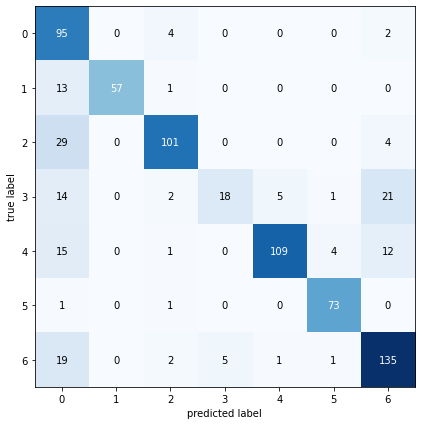

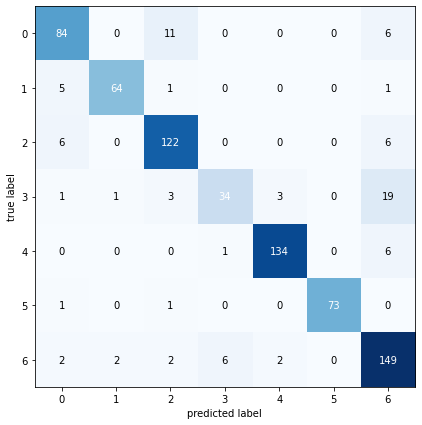

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
print('Confusion Matrix on Test Set by Model 1(KNN Classifier):')
print() 
fig, ax = plot_confusion_matrix(conf_mat=confusionmatrix1, figsize=(7, 7))
print('Confusion Matrix on Test Set by Model 2(SVM Classifier):')
print() 
fig, ax = plot_confusion_matrix(conf_mat=confusionmatrix2, figsize=(7, 7))

Precision and Recall both cannot be maximized for a model at the same time.

Better metric to judge a model depends on the problem statement. As we know that recall is TP/FN+TP, means how many trues are predicted out of all trues and Precision is TP/FP+TP, means out of the tryes predicted how many were actually true.

Suppose if we are building a model to ring alarm when there is a thief, so we will increase recall so that no true should be missed i.e., even if there is no thief the alarm will ring , there is no problem but if a thief is there and our model is unable to ring the alarm, our model is of no use.

Another example if you want to detect spam emails, we try tommaximize precision.Because if a soam email isnot detected as spam no major problem is cause. But if an important mail is detected as spam it will be a problem.

d) A bridge in Raipur is unstable and we want to avoid fatalities. Trucks and
Buses should be stopped while motorbikes and bicycles can be allowed. Which
of your 2 models do you think will be better for this task? Explain with the help of
Precision/Recall, ROC curve and AUC.

In [ ]:
prediction = model1.predict(np.array(testim))
print("For model 1(Knn Classifier): ")
print("Accuracy:", accuracy_score(test_target, prediction))
print("Recall Score((Micro)):", recall_score(test_target, prediction,average="micro"))
print("Precision(Micro):", precision_score(test_target, prediction, average="micro"))
print("Recall Score((Macro)):", recall_score(test_target, prediction,average="macro"))
print("Precision(Macro):", precision_score(test_target, prediction,average="macro"))


prediction = model2.predict(np.array(testim))
print("For model 1 (SVM Classifier): ")
print("Accuracy:", accuracy_score(test_target, prediction))
print("Recall Score((Micro)):", recall_score(test_target, prediction,average="micro"))
print("Precision(Micro):", precision_score(test_target, prediction, average="micro"))
print("Recall Score((Macro)):", recall_score(test_target, prediction,average="macro"))
print("Precision(Macro):", precision_score(test_target, prediction,average="macro"))

For model 1(Knn Classifier): 
Accuracy: 0.7882037533512064
Recall Score((Micro)): 0.7882037533512064
Precision(Micro): 0.7882037533512064
Recall Score((Macro)): 0.7666897298471712
Precision(Macro): 0.8346979838490519
For model 1 (SVM Classifier): 
Accuracy: 0.8847184986595175
Recall Score((Micro)): 0.8847184986595175
Precision(Micro): 0.8847184986595175
Recall Score((Macro)): 0.8626735431579541
Precision(Macro): 0.8950322591460066


In [ ]:
prediction1 = model1.predict(np.array(testim))
print("For model 1(Knn Classifier): ")
print( classification_report(test_target, prediction))


prediction2 = model2.predict(np.array(testim))
print("For model 1 (SVM Classifier): ")
print(classification_report(test_target, prediction))


For model 1(Knn Classifier): 
              precision    recall  f1-score   support

           1       0.85      0.83      0.84       101
           2       0.96      0.90      0.93        71
           3       0.87      0.91      0.89       134
           4       0.83      0.56      0.67        61
           5       0.96      0.95      0.96       141
           6       1.00      0.97      0.99        75
           7       0.80      0.91      0.85       163

    accuracy                           0.88       746
   macro avg       0.90      0.86      0.87       746
weighted avg       0.89      0.88      0.88       746

For model 1 (SVM Classifier): 
              precision    recall  f1-score   support

           1       0.85      0.83      0.84       101
           2       0.96      0.90      0.93        71
           3       0.87      0.91      0.89       134
           4       0.83      0.56      0.67        61
           5       0.96      0.95      0.96       141
           6     

In [ ]:
from sklearn.metrics import f1_score
prediction = model1.predict(np.array(testim))
print("For model 1:")
print("Micro F1 SCore: ", f1_score(test_target, prediction, average='micro'))
print("Macro F1 SCore: ", f1_score(test_target, prediction, average='macro'))

prediction = model1.predict(np.array(testim))
print("For model 2:")
print("Micro F1 SCore: ", f1_score(test_target, prediction, average='micro'))
print("Macro F1 SCore: ", f1_score(test_target, prediction, average='macro'))

For model 1:
Micro F1 SCore:  0.7882037533512064
Macro F1 SCore:  0.7718795625070018
For model 2:
Micro F1 SCore:  0.7882037533512064
Macro F1 SCore:  0.7718795625070018


Micro is a better measure because it gives equal weight and there is not bias.

### Final Captcha Breaker


Thus based on accuracy, precison, recall we see that model2 is better. Thus my final model is model2.

In [ ]:
prediction = model1.predict(np.array(testim))
print("For model 1(Knn Classifier): ")
print("Accuracy:", accuracy_score(test_target, prediction))
print("Recall Score((Micro)):", recall_score(test_target, prediction,average="micro"))
print("Precision(Micro):", precision_score(test_target, prediction, average="micro"))
print("Recall Score((Macro)):", recall_score(test_target, prediction,average="macro"))
print("Precision(Macro):", precision_score(test_target, prediction,average="macro"))


prediction = model2.predict(np.array(testim))
print("For model 1 (SVM Classifier): ")
print("Accuracy:", accuracy_score(test_target, prediction))
print("Recall Score((Micro)):", recall_score(test_target, prediction,average="micro"))
print("Precision(Micro):", precision_score(test_target, prediction, average="micro"))
print("Recall Score((Macro)):", recall_score(test_target, prediction,average="macro"))
print("Precision(Macro):", precision_score(test_target, prediction,average="macro"))

For model 1(Knn Classifier): 
Accuracy: 0.7882037533512064
Recall Score((Micro)): 0.7882037533512064
Precision(Micro): 0.7882037533512064
Recall Score((Macro)): 0.7666897298471712
Precision(Macro): 0.8346979838490519
For model 1 (SVM Classifier): 
Accuracy: 0.8847184986595175
Recall Score((Micro)): 0.8847184986595175
Precision(Micro): 0.8847184986595175
Recall Score((Macro)): 0.8626735431579541
Precision(Macro): 0.8950322591460066


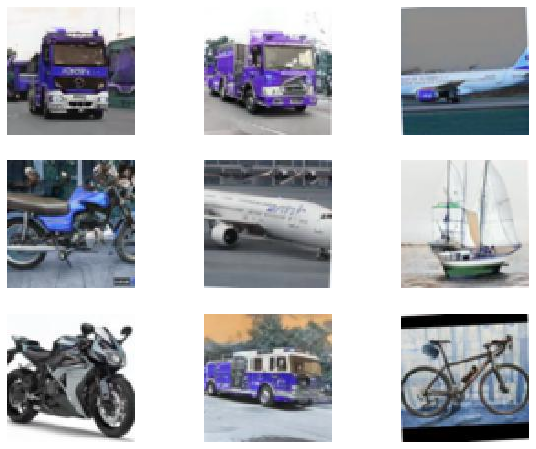

In [29]:
import matplotlib.pyplot as plt
def createcaptcha(captcha):
  fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10,8))
  for i in range(3):
        for j in range(3):
          random_image=random.choice(test_images)
          img=cv2.imread(random_image)
          axes[i,j].imshow(img)
          axes[i,j].axis("off")
          dsize = (128, 128) 
        #making all images of shape(128,128)
          img=cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
          img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          norm = np.zeros((800,800))
          img = cv2.normalize(img,norm,0,255,cv2.NORM_MINMAX)
          img=img.flatten()
          captcha.append(img)


captcha=[]
createcaptcha(captcha)

In [30]:
label=model2.predict(np.array(captcha))
print(label)
label=label.tolist()
res = max(set(label), key = label.count)
if(res==1):
  modelans='airplane'
elif(res==2):
  modelans='bicycle'
elif(res==3):
  modelans='boat'
elif(res==4):
  modelans='motorbus'
elif(res==5):
  modelans='motorcycle'
elif(res==6):
  modelans='seaplane'
elif(res==7):
  modelans='truck'

ans=input("Enter the class with maximum images: ")
print("Answer predicted by model: ", modelans)
print("Answer inputted by user", ans)
if(modelans==ans):
  print("Model guessed correctly")
else:
  print("Model did not guess correctly")

[7 7 3 5 1 3 5 7 2]
Enter the class with maximum images: truck
Answer predicted by model:  truck
Answer inputted by user truck
Model guessed correctly


# Captcha Breaker using Neural Networks

## Preparing Training Data

In [32]:
!pip install tensorflow_addons
import numpy as np
from tensorflow import keras
from re import L
import random
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import glob
import tensorflow_addons as tfa
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [33]:
# cloning
!git clone https://github.com/sarang-iitb/H-captcha-dataset
import zipfile
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()
unzip_data('/content/H-captcha-dataset/hcaptcha_dataset.zip')

fatal: destination path 'H-captcha-dataset' already exists and is not an empty directory.


In [34]:
import glob
classes=glob.glob('hcaptcha_dataset/train/*')
imagesbyclass={}
classes=list(map(lambda x: x.split("/")[-1], classes))
print("labels: ", classes)
for x in classes:
  imagesbyclass[x.split("/")[-1]]=len(glob.glob('hcaptcha_dataset/train/'+x+'/*.jpg'))+len(glob.glob('hcaptcha_dataset/test/'+x+'/*.jpg'))
print(imagesbyclass)

labels:  ['boat', 'truck', 'bicycle', 'motorbus', 'motorcycle', 'airplane', 'seaplane']
{'boat': 662, 'truck': 819, 'bicycle': 375, 'motorbus': 317, 'motorcycle': 733, 'airplane': 503, 'seaplane': 355}


In [35]:
test_images = glob.glob('hcaptcha_dataset/test/*/*.jpg')
training_images=glob.glob('hcaptcha_dataset/train/*/*.jpg')
print(test_images)
print("Total number of testing images: ", len(test_images))
print("Total number of training images: ", len(training_images))

['hcaptcha_dataset/test/boat/1650248778904_19.jpg', 'hcaptcha_dataset/test/boat/1650249143436_3.jpg', 'hcaptcha_dataset/test/boat/1650240329908_3.jpg', 'hcaptcha_dataset/test/boat/1650247666791_1.jpg', 'hcaptcha_dataset/test/boat/1650252835049_8.jpg', 'hcaptcha_dataset/test/boat/1650242535652_9.jpg', 'hcaptcha_dataset/test/boat/1650239956161_16.jpg', 'hcaptcha_dataset/test/boat/1650245451597_4.jpg', 'hcaptcha_dataset/test/boat/1650252451974_16.jpg', 'hcaptcha_dataset/test/boat/1650241806607_2.jpg', 'hcaptcha_dataset/test/boat/1650243573471_20.jpg', 'hcaptcha_dataset/test/boat/1650241414223_15.jpg', 'hcaptcha_dataset/test/boat/1650241797333_14.jpg', 'hcaptcha_dataset/test/boat/1650249517255_10.jpg', 'hcaptcha_dataset/test/boat/1650241058977_2.jpg', 'hcaptcha_dataset/test/boat/1650241404944_7.jpg', 'hcaptcha_dataset/test/boat/1650241058977_15.jpg', 'hcaptcha_dataset/test/boat/1650241040425_17.jpg', 'hcaptcha_dataset/test/boat/1650248778904_17.jpg', 'hcaptcha_dataset/test/boat/16502406758

In [36]:
#Normalizing the Image and converting all the images to same dimensions
images=glob.glob('hcaptcha_dataset/train/*/*.jpg')
image = cv2.imread(images[0], cv2.IMREAD_UNCHANGED) 
for x in images:
  img=cv2.imread(x)
  dsize = (32,32)   #Making all the images of same 32*32
  img=cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(x,img) 

In [37]:
# Making a new dataset that whose k folds will be similar

new_dataset=[]

for i in range(1,11):
  for label in classes:
    class_images=glob.glob('hcaptcha_dataset/train/'+label+'/*.jpg')
    l=len(class_images)
    start=int((i-1)*(l/10))
    end=int(i*(l/10))
    if i==10 and end<l :
      end=l
    for index in range(start-1, end):
      new_dataset.append(class_images[index])

In [38]:
#Checking that each fold in cross validation is similar data in our newdataset i.e., no fold has 0 image of any class 
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)

for train_index, test_index in kf.split(new_dataset):
  count_airplane=0
  count_bicycle=0
  count_boat=0
  count_motorbus=0
  count_motorcycle=0
  count_seaplane=0
  count_truck=0
  for i in range(0,len(test_index)):
    label=new_dataset[i].split('/')[-2]

    if(label=='airplane'):
      count_airplane+=1
    elif(label=='bicycle'):
      count_bicycle+=1
    elif(label=='boat'):
      count_boat+=1
    elif(label=='motorbus'):
      count_motorbus+=1
    elif(label=='motorcycle'):
      count_motorcycle+=1
    elif(label=='seaplane'):
      count_seaplane+=1
    elif(label=='truck'):
      count_truck+=1

  if(count_airplane==0 or count_boat==0 or count_bicycle==0 or count_motorbus==0 or count_seaplane==0 or count_motorcycle==0 or count_truck==0):
    print("Invalid shuffling")
  else:
    print("Valid Shuffling")

Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling
Valid Shuffling


In [39]:
import numpy as np

#Normalizing the image and preparing X and y
image_data=[]
target=[]
c=1
for i in new_dataset:
  img=cv2.imread(i, cv2.IMREAD_UNCHANGED)
  img=img/255
  if(c<10):
    print("normalized: ", img)

  img=img.flatten()
  if(c<10):
    print("flattened: ", img)
  c+=1
  image_data.append(img)

  label=i.split('/')[-2]
  if(label=='airplane'):
    target.append([1,0,0,0,0,0,0])
  elif(label=='bicycle'):
    target.append([0,1,0,0,0,0,0])
  elif(label=='boat'):
    target.append([0,0,1,0,0,0,0])
  elif(label=='motorbus'):
    target.append([0,0,0,1,0,0,0])
  elif(label=='motorcycle'):
    target.append([0,0,0,0,1,0,0])
  elif(label=='seaplane'):
    target.append([0,0,0,0,0,1,0])
  elif(label=='truck'):
    target.append([0,0,0,0,0,0,1])

image_data=np.array(image_data)
target=np.array(target)

normalized:  [[0.63137255 0.63137255 0.63529412 ... 0.61176471 0.61176471 0.60784314]
 [0.57647059 0.57647059 0.57647059 ... 0.58039216 0.57254902 0.56862745]
 [0.55294118 0.55686275 0.56470588 ... 0.57647059 0.57254902 0.56862745]
 ...
 [0.34509804 0.34509804 0.34901961 ... 0.32156863 0.32156863 0.3254902 ]
 [0.3372549  0.32941176 0.31372549 ... 0.31764706 0.32156863 0.31372549]
 [0.3254902  0.32941176 0.33333333 ... 0.31764706 0.32156863 0.30980392]]
flattened:  [0.63137255 0.63137255 0.63529412 ... 0.31764706 0.32156863 0.30980392]
normalized:  [[0.72156863 0.71372549 0.70588235 ... 0.65882353 0.6627451  0.71372549]
 [0.67058824 0.66666667 0.66666667 ... 0.6627451  0.66666667 0.71764706]
 [0.6745098  0.6745098  0.67058824 ... 0.66666667 0.67058824 0.70980392]
 ...
 [0.25882353 0.25490196 0.23137255 ... 0.17254902 0.20784314 0.21568627]
 [0.21568627 0.19607843 0.21176471 ... 0.21176471 0.22352941 0.21568627]
 [0.2        0.20784314 0.16078431 ... 0.2745098  0.28627451 0.32156863]]
fl

In [48]:
micro_f1_score=tfa.metrics.F1Score(num_classes=7, average="micro", name="micro_f1_score")
macro_f1_score=tfa.metrics.F1Score(num_classes=7, average="macro", name="macro_f1_score")



In [46]:
from sklearn.model_selection import train_test_split
X=image_data
y=target
x_train, x_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=102)

## A. BaseLine Neural Network

In [42]:
model = keras.Sequential([keras.layers.Dense(256, input_shape=( 1024,  ), activation='sigmoid'),
keras.layers.Dense(128, activation='sigmoid'),
keras.layers.Dense(64, activation='sigmoid'),
keras.layers.Dense(7, activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', macro_f1_score, micro_f1_score])

model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/50
20/20 [==============================] - 2s 37ms/step - loss: 1.9356 - accuracy: 0.2113 - macro_f1_score: 0.0949 - micro_f1_score: 0.2113 - val_loss: 1.8737 - val_accuracy: 0.1974 - val_macro_f1_score: 0.0502 - val_micro_f1_score: 0.1974
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 1.7839 - accuracy: 0.3478 - macro_f1_score: 0.1910 - micro_f1_score: 0.3478 - val_loss: 1.7151 - val_accuracy: 0.4110 - val_macro_f1_score: 0.2246 - val_micro_f1_score: 0.4110
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 1.5925 - accuracy: 0.4190 - macro_f1_score: 0.2227 - micro_f1_score: 0.4190 - val_loss: 1.5466 - val_accuracy: 0.4223 - val_macro_f1_score: 0.2316 - val_micro_f1_score: 0.4223
Epoch 4/50
20/20 [==============================] - 0s 14ms/step - loss: 1.4505 - accuracy: 0.4632 - macro_f1_score: 0.2589 - micro_f1_score: 0.4632 - val_loss: 1.4560 - val_accuracy: 0.4272 - val_macro_f1_score: 0.2581 - val_micro_f1_score: 0.4272
Epoc

In [43]:
_, accuracy, macro_f1_score, micro_f1_score = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
print('Micro_f1_score: %.2f' % (micro_f1_score*100))
print('Macro_f1_score: %.2f' % (macro_f1_score*100))

97/97 [==============================] - 0s 5ms/step - loss: 0.3563 - accuracy: 0.8854 - macro_f1_score: 0.8750 - micro_f1_score: 0.8854
Accuracy: 88.54
Micro_f1_score: 88.54
Macro_f1_score: 87.50


## B. Experimenting with number of neurons and number of layers

In [45]:
def build_model( n_hidden, n_neurons, learning_rate=0.0001):
 model = keras.models.Sequential()
 for layer in range(n_hidden):
  model.add(keras.layers.Dense(n_neurons, activation="sigmoid"))
 
 model.add(keras.layers.Dense(7, activation="softmax"))
 optimizer  = keras.optimizers.SGD(learning_rate)
 model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy', macro_f1_score, micro_f1_score])
 return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
import tensorflow
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
 "n_hidden": [ 1, 2, 3,4, 5],
 "n_neurons": np.arange(8, 513)
 
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
# rnd_search_cv.fit(X, y, epochs=50)

rnd_search_cv.fit(X, y, epochs=50, batch_size=128)

Streaming output truncated to the last 5000 lines.
Epoch 26/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4994 - accuracy: 0.8397 - macro_f1_score: 0.8261 - micro_f1_score: 0.8397
Epoch 27/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4845 - accuracy: 0.8429 - macro_f1_score: 0.8310 - micro_f1_score: 0.8429
Epoch 28/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4875 - accuracy: 0.8474 - macro_f1_score: 0.8335 - micro_f1_score: 0.8474
Epoch 29/50
20/20 [==============================] - 0s 9ms/step - loss: 0.5050 - accuracy: 0.8316 - macro_f1_score: 0.8152 - micro_f1_score: 0.8316
Epoch 30/50
20/20 [==============================] - 0s 10ms/step - loss: 0.4681 - accuracy: 0.8490 - macro_f1_score: 0.8365 - micro_f1_score: 0.8490
Epoch 31/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4624 - accuracy: 0.8494 - macro_f1_score: 0.8350 - micro_f1_score: 0.8494
Epoch 32/50
20/20 [==============================] - 0

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f53f1788250>,
                   param_distributions={'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': array([  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70...
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
       489, 490, 491, 492, 493, 494, 495,

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_ )
model = rnd_search_cv.best_estimator_.model
_, accuracy, macro_f1_score, micro_f1_score = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
print('Micro_f1_score: %.2f' % (micro_f1_score*100))
print('Macro_f1_score: %.2f' % (macro_f1_score*100))

{'n_neurons': 201, 'n_hidden': 2}
-0.5532315850257874
97/97 [==============================] - 1s 3ms/step - loss: 0.3192 - accuracy: 0.8928 - macro_f1_score: 0.8880 - micro_f1_score: 0.8928
Accuracy: 89.28
Micro_f1_score: 89.28
Macro_f1_score: 88.80


This shows that the best model uses two hidden layers in which the number of neurons is the last hidden layer is 201.

Thus best paramters till now are:
<br>Number of Hidden layers: 2
<br>Number of neurons: Hidden Layer 0: 512
<br> Number of neurons: Hidden Layer 1: 201


## C. Experimenting for best activation function

In [ ]:
def build_model( activation_functions="sigmoid", learning_rate=0.0001):
 model = keras.models.Sequential()
 model.add(keras.layers.Dense(512, activation=activation_functions))
 model.add(keras.layers.Dense(201, activation=activation_functions))
 model.add(keras.layers.Dense(7, activation="softmax"))
 model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', macro_f1_score, micro_f1_score])
 return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':


In [ ]:
#using Random Search to find the best paramaters
import tensorflow
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
 "activation_functions": [ "relu", "sigmoid", "tanh", "elu"]
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(X, y, epochs=50, batch_size=128)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


20/20 [==============================] - 1s 15ms/step - loss: 1.5700 - accuracy: 0.4182 - macro_f1_score: 0.3702 - micro_f1_score: 0.4182
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 1.0788 - accuracy: 0.5931 - macro_f1_score: 0.5603 - micro_f1_score: 0.5931
Epoch 3/50
20/20 [==============================] - 0s 15ms/step - loss: 0.9096 - accuracy: 0.6972 - macro_f1_score: 0.6666 - micro_f1_score: 0.6972
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 0.8135 - accuracy: 0.7223 - macro_f1_score: 0.6924 - micro_f1_score: 0.7223
Epoch 5/50
20/20 [==============================] - 0s 15ms/step - loss: 0.7206 - accuracy: 0.7632 - macro_f1_score: 0.7353 - micro_f1_score: 0.7632
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - loss: 0.6732 - accuracy: 0.7765 - macro_f1_score: 0.7546 - micro_f1_score: 0.7765
Epoch 7/50
20/20 [==============================] - 0s 16ms/step - loss: 0.6459 - accuracy: 0.7931 - macro_f1_score: 

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f53f96594d0>,
                   param_distributions={'activation_functions': ['relu',
                                                                 'sigmoid',
                                                                 'tanh',
                                                                 'elu']})

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_ )
model = rnd_search_cv.best_estimator_.model
_, accuracy, macro_f1_score, micro_f1_score = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
print('Micro_f1_score: %.2f' % (micro_f1_score*100))
print('Macro_f1_score: %.2f' % (macro_f1_score*100))

{'activation_functions': 'tanh'}
-0.5031643271446228
97/97 [==============================] - 1s 4ms/step - loss: 0.1270 - accuracy: 0.9563 - macro_f1_score: 0.9529 - micro_f1_score: 0.9563
Accuracy: 95.63
Micro_f1_score: 95.63
Macro_f1_score: 95.29


Thus best activation function is tanh for this model.

## D. Experimenting with Different Regularization techniques

#### 1. Early stopping 

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

model = keras.Sequential([keras.layers.Dense(512, input_shape=( 1024,  ), activation='tanh'),
keras.layers.Dense(201, activation='tanh'),
keras.layers.Dense(7, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', macro_f1_score, micro_f1_score])
score=0
skf = KFold(n_splits=10)
for train_index, test_index in skf.split(X, y):
  X_train, X_valid = X[train_index], X[test_index]
  y_train, y_valid = y[train_index], y[test_index]
  model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])
  _, accuracy, macro_f1_score, micro_f1_score=model.evaluate(X_valid, y_valid)
  print(accuracy)
  score+=accuracy
score=score/10
print("K Fold Validation Score using Early Stopping Regulaization: ", score)

Epoch 1/50
22/22 [==============================] - 1s 33ms/step - loss: 1.9496 - accuracy: 0.4091 - macro_f1_score: 0.3523 - micro_f1_score: 0.4091 - val_loss: 1.2838 - val_accuracy: 0.4887 - val_macro_f1_score: 0.3480 - val_micro_f1_score: 0.4887
Epoch 2/50
22/22 [==============================] - 0s 18ms/step - loss: 1.0741 - accuracy: 0.6186 - macro_f1_score: 0.5578 - micro_f1_score: 0.6186 - val_loss: 0.9954 - val_accuracy: 0.6472 - val_macro_f1_score: 0.6583 - val_micro_f1_score: 0.6472
Epoch 3/50
22/22 [==============================] - 0s 18ms/step - loss: 0.8178 - accuracy: 0.7211 - macro_f1_score: 0.6926 - micro_f1_score: 0.7211 - val_loss: 0.7901 - val_accuracy: 0.7411 - val_macro_f1_score: 0.7294 - val_micro_f1_score: 0.7411
Epoch 4/50
22/22 [==============================] - 0s 17ms/step - loss: 0.7317 - accuracy: 0.7567 - macro_f1_score: 0.7360 - micro_f1_score: 0.7567 - val_loss: 0.8309 - val_accuracy: 0.6926 - val_macro_f1_score: 0.6572 - val_micro_f1_score: 0.6926
Epoc

Thus from the above result we can see that the best early stopping regulizer is whose cross fold validation score is 0.9426953315734863

#### 2. Drop Out Rate

In [ ]:
import numpy as np
from sklearn.model_selection import KFold


model =keras.Sequential()
model.add(keras.layers.Dropout(0.2, input_shape=(1024,)))
model.add(keras.layers.Dense(512, activation='tanh'))
model.add(keras.layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', macro_f1_score, micro_f1_score])
skf = KFold(n_splits=10)

score=0

for train_index, test_index in skf.split(X, y):

  X_train, X_valid = X[train_index], X[test_index]
  y_train, y_valid = y[train_index], y[test_index]
  model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid))
  _, accuracy, macro_f1_score, micro_f1_score=model.evaluate(X_valid, y_valid)
  score+=accuracy
  print(accuracy)
score=score/10
print("K Fold Score for Dropout regulizer: ", score)

Epoch 1/50
22/22 [==============================] - 1s 34ms/step - loss: 1.7263 - accuracy: 0.4340 - macro_f1_score: 0.3930 - micro_f1_score: 0.4340 - val_loss: 1.1593 - val_accuracy: 0.5340 - val_macro_f1_score: 0.5375 - val_micro_f1_score: 0.5340
Epoch 2/50
22/22 [==============================] - 0s 17ms/step - loss: 1.0034 - accuracy: 0.6384 - macro_f1_score: 0.5918 - micro_f1_score: 0.6384 - val_loss: 0.9621 - val_accuracy: 0.6893 - val_macro_f1_score: 0.6400 - val_micro_f1_score: 0.6893
Epoch 3/50
22/22 [==============================] - 0s 17ms/step - loss: 0.8811 - accuracy: 0.6963 - macro_f1_score: 0.6686 - micro_f1_score: 0.6963 - val_loss: 0.9610 - val_accuracy: 0.6764 - val_macro_f1_score: 0.6105 - val_micro_f1_score: 0.6764
Epoch 4/50
22/22 [==============================] - 1s 23ms/step - loss: 0.7731 - accuracy: 0.7485 - macro_f1_score: 0.7222 - micro_f1_score: 0.7485 - val_loss: 0.8051 - val_accuracy: 0.7379 - val_macro_f1_score: 0.7077 - val_micro_f1_score: 0.7379
Epoc

K Fold Score for Dropout regulizer:  0.9572794437408447

#### 3.L1 Sparse Regulizer

In [ ]:

import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold

model = keras.Sequential([keras.layers.Dense(512, input_shape=( 1024,  ), activation='tanh', kernel_regularizer=keras.regularizers.l1(0.01)),
keras.layers.Dense(201, activation='tanh', kernel_regularizer=keras.regularizers.l1(0.01)),
keras.layers.Dense(7, activation='softmax', kernel_regularizer=keras.regularizers.l1(0.01))])
optimizer = keras.optimizers.SGD(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', macro_f1_score, micro_f1_score])
score=0
skf = KFold(n_splits=10)
for train_index, test_index in skf.split(X, y):
  X_train, X_valid = X[train_index], X[test_index]
  y_train, y_valid = y[train_index], y[test_index]
  model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid))
  _, accuracy, macro_f1_score, micro_f1_score=model.evaluate(X_valid, y_valid)
  print(accuracy)
  score+=accuracy
score=score/10
print("K Fold Validation Score using Optimizer Learning Rate: ", score)

Epoch 1/50
22/22 [==============================] - 1s 34ms/step - loss: 214.4216 - accuracy: 0.1364 - macro_f1_score: 0.0978 - micro_f1_score: 0.1607 - val_loss: 214.3174 - val_accuracy: 0.1392 - val_macro_f1_score: 0.0605 - val_micro_f1_score: 0.1392
Epoch 2/50
22/22 [==============================] - 0s 18ms/step - loss: 214.2161 - accuracy: 0.1450 - macro_f1_score: 0.0698 - micro_f1_score: 0.1450 - val_loss: 214.1211 - val_accuracy: 0.1327 - val_macro_f1_score: 0.0673 - val_micro_f1_score: 0.1327
Epoch 3/50
22/22 [==============================] - 0s 18ms/step - loss: 214.0251 - accuracy: 0.1486 - macro_f1_score: 0.0796 - micro_f1_score: 0.1486 - val_loss: 213.9363 - val_accuracy: 0.1424 - val_macro_f1_score: 0.0796 - val_micro_f1_score: 0.1424
Epoch 4/50
22/22 [==============================] - 0s 21ms/step - loss: 213.8437 - accuracy: 0.1504 - macro_f1_score: 0.0848 - micro_f1_score: 0.1504 - val_loss: 213.7595 - val_accuracy: 0.1683 - val_macro_f1_score: 0.1068 - val_micro_f1_sc

## E. Experimenting with optimizers

#### 1. Optimizer: Adagrad

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

model = keras.Sequential([keras.layers.Dense(512, input_shape=( 1024,  ), activation='tanh'),
keras.layers.Dense(201, activation='tanh'),
keras.layers.Dense(7, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy', macro_f1_score, micro_f1_score])
score=0
skf = KFold(n_splits=10)
for train_index, test_index in skf.split(X, y):
  X_train, X_valid = X[train_index], X[test_index]
  y_train, y_valid = y[train_index], y[test_index]
  model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid))
  _, accuracy, macro_f1_score, micro_f1_score=model.evaluate(X_valid, y_valid)
  print(accuracy)
  score+=accuracy
score=score/10
print("K Fold Validation Score using Early Stopping Regulaization: ", score)

Epoch 1/50
22/22 [==============================] - 3s 62ms/step - loss: 1.8948 - accuracy: 0.2112 - macro_f1_score: 0.1622 - micro_f1_score: 0.2112 - val_loss: 1.7767 - val_accuracy: 0.2880 - val_macro_f1_score: 0.1876 - val_micro_f1_score: 0.2880
Epoch 2/50
22/22 [==============================] - 1s 37ms/step - loss: 1.6949 - accuracy: 0.3627 - macro_f1_score: 0.2715 - micro_f1_score: 0.3627 - val_loss: 1.6539 - val_accuracy: 0.3883 - val_macro_f1_score: 0.2945 - val_micro_f1_score: 0.3883
Epoch 3/50
22/22 [==============================] - 1s 30ms/step - loss: 1.5787 - accuracy: 0.4404 - macro_f1_score: 0.3429 - micro_f1_score: 0.4404 - val_loss: 1.5542 - val_accuracy: 0.4563 - val_macro_f1_score: 0.3546 - val_micro_f1_score: 0.4563
Epoch 4/50
22/22 [==============================] - 1s 33ms/step - loss: 1.4883 - accuracy: 0.5013 - macro_f1_score: 0.3978 - micro_f1_score: 0.5013 - val_loss: 1.4846 - val_accuracy: 0.4693 - val_macro_f1_score: 0.3521 - val_micro_f1_score: 0.4693
Epoc

K Fold Validation Score using Adagrad Optimizer:  0.8280670881271363

#### 2. Optimizer: SGD (Learning Rate=0.0001)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

model = keras.Sequential([keras.layers.Dense(512, input_shape=( 1024,  ), activation='tanh'),
keras.layers.Dense(201, activation='tanh'),
keras.layers.Dense(7, activation='softmax')])
optimizer = keras.optimizers.SGD(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', macro_f1_score, micro_f1_score])
score=0
skf = KFold(n_splits=10)
for train_index, test_index in skf.split(X, y):
  X_train, X_valid = X[train_index], X[test_index]
  y_train, y_valid = y[train_index], y[test_index]
  model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_valid, y_valid))
  _, accuracy, macro_f1_score, micro_f1_score=model.evaluate(X_valid, y_valid)
  print(accuracy)
  score+=accuracy
score=score/10
print("K Fold Validation Score using Optimizer Learning Rate: ", score)

Epoch 1/50
22/22 [==============================] - 1s 28ms/step - loss: 2.1079 - accuracy: 0.1670 - macro_f1_score: 0.1560 - micro_f1_score: 0.2399 - val_loss: 2.0891 - val_accuracy: 0.1618 - val_macro_f1_score: 0.0569 - val_micro_f1_score: 0.1618
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 2.0669 - accuracy: 0.1716 - macro_f1_score: 0.0566 - micro_f1_score: 0.1716 - val_loss: 2.0536 - val_accuracy: 0.1683 - val_macro_f1_score: 0.0583 - val_micro_f1_score: 0.1683
Epoch 3/50
22/22 [==============================] - 0s 17ms/step - loss: 2.0340 - accuracy: 0.1778 - macro_f1_score: 0.0614 - micro_f1_score: 0.1778 - val_loss: 2.0251 - val_accuracy: 0.1748 - val_macro_f1_score: 0.0606 - val_micro_f1_score: 0.1748
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 2.0074 - accuracy: 0.1846 - macro_f1_score: 0.0677 - micro_f1_score: 0.1846 - val_loss: 2.0026 - val_accuracy: 0.1812 - val_macro_f1_score: 0.0659 - val_micro_f1_score: 0.1812
Epoc

K Fold Validation Score using SGD Optimizer Learning Rate(learning rate=0.0001):  0.6202002674341202

## Best Model

Best Architechture and parameters found till now:
<br>Number of layers: 2
<br>Number of neurons in output of layer 1: 512
<br>Number of neurons in ouput of layer 2: 201
<br>Ouput layer neurons: 7
<br>Optimizer: Adam
<br>Activation function: tanh
<br>Regulizer: Drop out (rate= 0.2)

In [49]:
# Best Model
from tensorflow import keras
model =keras.Sequential()
model.add(keras.layers.Dropout(0.2, input_shape=(1024,)))
model.add(keras.layers.Dense(512, activation='tanh'))
model.add(keras.layers.Dense(201, activation='tanh'))
model.add(keras.layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', macro_f1_score, micro_f1_score])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', macro_f1_score, micro_f1_score])

model.fit(x_train, y_train, epochs=50, batch_size=128)
                                  

Epoch 1/50
20/20 [==============================] - 1s 21ms/step - loss: 1.7041 - accuracy: 0.4336 - macro_f1_score: 0.3799 - micro_f1_score: 0.4336
Epoch 2/50
20/20 [==============================] - 0s 20ms/step - loss: 1.0634 - accuracy: 0.6368 - macro_f1_score: 0.5895 - micro_f1_score: 0.6368
Epoch 3/50
20/20 [==============================] - 0s 18ms/step - loss: 0.9086 - accuracy: 0.6834 - macro_f1_score: 0.6313 - micro_f1_score: 0.6834
Epoch 4/50
20/20 [==============================] - 0s 19ms/step - loss: 0.8126 - accuracy: 0.7154 - macro_f1_score: 0.6819 - micro_f1_score: 0.7154
Epoch 5/50
20/20 [==============================] - 0s 20ms/step - loss: 0.7658 - accuracy: 0.7364 - macro_f1_score: 0.7042 - micro_f1_score: 0.7364
Epoch 6/50
20/20 [==============================] - 0s 20ms/step - loss: 0.7240 - accuracy: 0.7445 - macro_f1_score: 0.7245 - micro_f1_score: 0.7445
Epoch 7/50
20/20 [==============================] - 0s 21ms/step - loss: 0.6763 - accuracy: 0.7700 - macro

**On Validation Data**

In [50]:
_, accuracy, macro_f1_score, micro_f1_score = model.evaluate(x_valid, y_valid)
print('Accuracy: %.2f' % (accuracy*100))
print('Micro_f1_score: %.2f' % (micro_f1_score*100))
print('Macro_f1_score: %.2f' % (macro_f1_score*100))



20/20 [==============================] - 0s 5ms/step - loss: 0.4926 - accuracy: 0.8317 - macro_f1_score: 0.8178 - micro_f1_score: 0.8317
Accuracy: 83.17
Micro_f1_score: 83.17
Macro_f1_score: 81.78


**On Training Data**

In [51]:
_, accuracy, macro_f1_score, micro_f1_score = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
print('Micro_f1_score: %.2f' % (micro_f1_score*100))
print('Macro_f1_score: %.2f' % (macro_f1_score*100))

97/97 [==============================] - 0s 5ms/step - loss: 0.2487 - accuracy: 0.9197 - macro_f1_score: 0.9124 - micro_f1_score: 0.9197
Accuracy: 91.97
Micro_f1_score: 91.97
Macro_f1_score: 91.24


**Captcha Breaker**

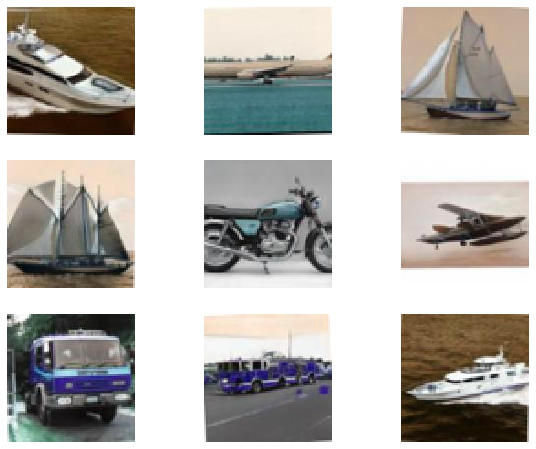

In [59]:
import matplotlib.pyplot as plt
def createcaptcha(captcha):
  fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10,8))
  for i in range(3):
        for j in range(3):
          random_image=random.choice(test_images)
          img=cv2.imread(random_image)
          axes[i,j].imshow(img)
          axes[i,j].axis("off")
          dsize = (32, 32)
      
          img=cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
          img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          img = img/255
          img=img.flatten()
          captcha.append(img)


captcha=[]
createcaptcha(captcha)

In [61]:
import numpy

pred=model.predict(numpy.array(captcha))


1/1 [==============================] - 0s 38ms/step


In [63]:
d = {
  "0": "airplane",
  "1": "bicycle",
  "2": "boat",
  "3":"motorbus",
  "4":"motorcycle",
  "5":"seaplane",
  "6":"truck",
}
label=[]
for x in pred:
  
  x=x.tolist()
  max_value = max(x)
  max_index = x.index(max_value)
  label.append(d[str(max_index)])



modelans = max(set(label), key = label.count)


ans=input("Enter the class with maximum images. Select from airplane, bicycle, boat, motorbus, motorcycle, seaplane and truck: ")
print("Answer predicted by model: ", modelans)
print("Answer inputted by user", ans)
if(modelans==ans):
  print("Model guessed correctly")
else:
  print("Model guessed correctly")


Enter the class with maximum images. Select from airplane, bicycle, boat, motorbus, motorcycle, seaplane and truck: boat
Answer predicted by model:  boat
Answer inputted by user boat
Model guessed correctly
